# Building Gaze Classification Model

## 1. Download Data and Import Dependencies

Data set used in this notebook is the "Columbia Gaze Data Set" by the Computer Science Department of Columbia University, New York.

In [ ]:
!wget https://www.cs.columbia.edu/CAVE/databases/columbia_gaze/columbia_gaze_data_set.zip

--2021-07-12 10:40:54--  https://www.cs.columbia.edu/CAVE/databases/columbia_gaze/columbia_gaze_data_set.zip
Resolving www.cs.columbia.edu (www.cs.columbia.edu)... 128.59.11.206
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2378561401 (2.2G) [application/zip]
Saving to: ‘columbia_gaze_data_set.zip’

columbia_gaze_data_ 100%[===================>]   2.21G  30.5MB/s    in 74s     

2021-07-12 10:42:08 (30.8 MB/s) - ‘columbia_gaze_data_set.zip’ saved [2378561401/2378561401]



In [ ]:
!unzip columbia_gaze_data_set.zip

Streaming output truncated to the last 5000 lines.
  inflating: Columbia Gaze Data Set/0011/0011_2m_30P_-10V_15H.jpg  
  inflating: Columbia Gaze Data Set/0011/0011_2m_30P_-10V_5H.jpg  
  inflating: Columbia Gaze Data Set/0011/0011_2m_30P_0V_-10H.jpg  
  inflating: Columbia Gaze Data Set/0011/0011_2m_30P_0V_-15H.jpg  
  inflating: Columbia Gaze Data Set/0011/0011_2m_30P_0V_-5H.jpg  
  inflating: Columbia Gaze Data Set/0011/0011_2m_30P_0V_0H.jpg  
  inflating: Columbia Gaze Data Set/0011/0011_2m_30P_0V_10H.jpg  
  inflating: Columbia Gaze Data Set/0011/0011_2m_30P_0V_15H.jpg  
  inflating: Columbia Gaze Data Set/0011/0011_2m_30P_0V_5H.jpg  
  inflating: Columbia Gaze Data Set/0011/0011_2m_30P_10V_-10H.jpg  
  inflating: Columbia Gaze Data Set/0011/0011_2m_30P_10V_-15H.jpg  
  inflating: Columbia Gaze Data Set/0011/0011_2m_30P_10V_-5H.jpg  
  inflating: Columbia Gaze Data Set/0011/0011_2m_30P_10V_0H.jpg  
  inflating: Columbia Gaze Data Set/0011/0011_2m_30P_10V_10H.jpg  
  inflating: Col

We first unzip the dataset to analyze its content. The whole dataset has 56 folders. Each folder containing a specific subject doing 5 head poses with 21 eye gaze for each head pose.

Next, dependencies and frameworks needed in this notebook is imported.

In [ ]:
import os
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras import layers
from keras import Model

## 2. Data Split

Here is the interpretation of 5 head poses and 21 eye gazes for each head pose (Source: https://www.cs.columbia.edu/CAVE/databases/columbia_gaze/). 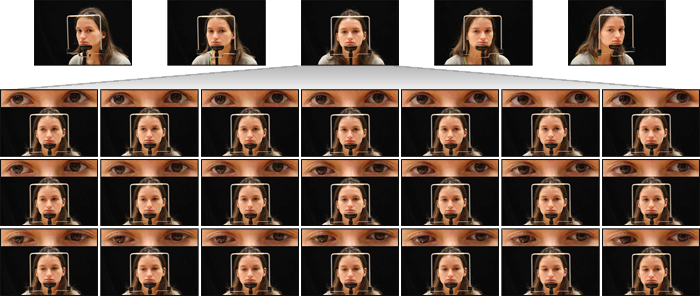

For the "focus" class we pick the image with 9 type of eye gaze (having horizontal gaze angle of 0°, ±5° and vertical gaze angle of 0°, ±10°, marked with red rectangle), and the rest will get into the "not focus" class.

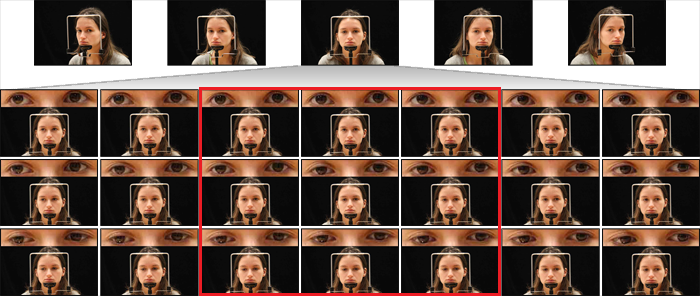

For the training data, we manually separate the unzipped data set into our criteria of "focus" and "not focus", pick the first 12 subjects, and upload the file to Google Drive. We reduce the image number of "not focus" class by dismissing random head pose and eye gazes from every subjects equally. This is done to avoid class imbalance. The final data set includes 514 images from "focus" class and 510 images from "not focus" class. The data set is then uploaded to this notebook author's Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unrar x '/content/gdrive/MyDrive/Dataset/dataset_12.rar' '/content/'


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/gdrive/MyDrive/Dataset/dataset_12.rar

Creating    /content/dataset_12                                       OK
Creating    /content/dataset_12/focus                                 OK
Extracting  /content/dataset_12/focus/0001_2m_-15P_-10V_-5H.jpg            0%  OK 
Extracting  /content/dataset_12/focus/0001_2m_-15P_-10V_5H.jpg             0%  OK 
Extracting  /content/dataset_12/focus/0001_2m_-15P_0V_-5H.jpg              0%  OK 
Extracting  /content/dataset_12/focus/0001_2m_-15P_0V_0H.jpg               0%  OK 
Extracting  /content/dataset_12/focus/0001_2m_-15P_0V_5H.jpg               0%  OK 
Extracting  /content/dataset_12/focus/0001_2m_-15P_10V_-5H.jpg             0%  OK 
Extracting  /content/dataset_12/focus/0001_2m_-15P_10V_0H.jpg              0%  OK 
Extracting  /content/dataset_12/focus/0001_2m_-15P_10V_5H.jpg            

For the validation data, we pick the next 2 subjects and do the same treatment as to the training data. In summary, we only use 14 subjects from the whole Columbia Gaze Dataset to build the ML model in this notebook.

In [ ]:
!unrar x '/content/gdrive/MyDrive/Dataset/valid_15.rar' '/content/'


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/gdrive/MyDrive/Dataset/valid_15.rar

Creating    /content/valid_15                                         OK
Creating    /content/valid_15/focus                                   OK
Extracting  /content/valid_15/focus/0016_2m_-15P_-10V_-5H.jpg              0%  OK 
Extracting  /content/valid_15/focus/0016_2m_-15P_-10V_0H.jpg               1%  OK 
Extracting  /content/valid_15/focus/0016_2m_-15P_-10V_5H.jpg               1%  OK 
Extracting  /content/valid_15/focus/0016_2m_-15P_0V_-5H.jpg                2%  OK 
Extracting  /content/valid_15/focus/0016_2m_-15P_0V_0H.jpg                 2%  OK 
Extracting  /content/valid_15/focus/0016_2m_-15P_0V_5H.jpg                 3%  OK 
Extracting  /content/valid_15/focus/0016_2m_-15P_10V_-5H.jpg               3%  OK 
Extracting  /content/valid_15/focus/0016_2m_-15P_10V_0H.jpg                

Using ImageDataGenerator to feed image data into neural network.

In [ ]:
train_generator = ImageDataGenerator(rescale=1/255).flow_from_directory('/content/dataset_12',
                                                                          batch_size=32,
                                                                          class_mode='binary',
                                                                          target_size=(256, 256))

Found 1024 images belonging to 2 classes.


In [ ]:
validation_generator = ImageDataGenerator(rescale=1/255).flow_from_directory('/content/valid_15',
                                                              batch_size=20,
                                                              class_mode='binary',
                                                              target_size=(256, 256))

Found 180 images belonging to 2 classes.


## 3. Model Preparation

We are using pre-trained model VGG16. Here is the model summary:

In [ ]:
pre_trained_model = VGG16(input_shape = (256, 256, 3), include_top = False)

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
for layer in pre_trained_model.layers:
  layer.trainable = False
pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

We freeze the layers to make training process faster, then connect the output from block5_pool layer into our network.

In [ ]:
last_layer = pre_trained_model.get_layer('block5_pool')
print(last_layer.output_shape)

(None, 8, 8, 512)


In [ ]:
last_output = last_layer.output

In [ ]:
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

For the base model, we use adam optimizer, binary_crossentropy loss function, and accuracy metrics. After being compiled, our final model summary is shown below.

In [ ]:
model.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

We implement callback method to stop training process once accuracy score reaches 90%.

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.90):
      self.model.stop_training = True

## 4. Training Phase

Define our callback and start the training.

In [ ]:
callbacks = myCallback()

In [ ]:
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 5,
                    steps_per_epoch = 32,
                    validation_steps = 9,
                    verbose = 2,
                    callbacks = [callbacks])

Epoch 1/5
32/32 - 262s - loss: 5.3493 - acc: 0.4736 - val_loss: 1.2305 - val_acc: 0.5000
Epoch 2/5
32/32 - 208s - loss: 1.3939 - acc: 0.5225 - val_loss: 1.3838 - val_acc: 0.5000
Epoch 3/5
32/32 - 206s - loss: 1.1534 - acc: 0.5293 - val_loss: 0.7082 - val_acc: 0.5000
Epoch 4/5
32/32 - 209s - loss: 0.7912 - acc: 0.5078 - val_loss: 0.6982 - val_acc: 0.5111
Epoch 5/5
32/32 - 205s - loss: 0.7255 - acc: 0.5215 - val_loss: 0.6940 - val_acc: 0.5167


Export model to .pb format. And zip the entire folder so it can be downloaded in a single process.

In [ ]:
model.save('the_sentinel')

INFO:tensorflow:Assets written to: the_sentinel/assets


In [ ]:
!zip -r /content/the_sentinel.zip /content/the_sentinel

  adding: content/the_sentinel/ (stored 0%)
  adding: content/the_sentinel/keras_metadata.pb (deflated 95%)
  adding: content/the_sentinel/variables/ (stored 0%)
  adding: content/the_sentinel/variables/variables.data-00000-of-00001 (deflated 26%)
  adding: content/the_sentinel/variables/variables.index (deflated 67%)
  adding: content/the_sentinel/assets/ (stored 0%)
  adding: content/the_sentinel/saved_model.pb (deflated 90%)


Trying to do an inference.

Saving WIN_20210714_11_12_22_Pro.jpg to WIN_20210714_11_12_22_Pro (4).jpg
WIN_20210714_11_12_22_Pro.jpg
Not Focus
[[0.5133004]]


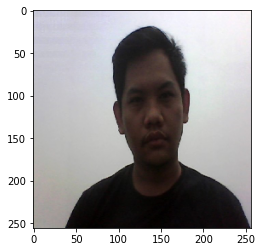

In [ ]:
%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, target_size=(256, 256))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  uploaded_image = np.vstack([x])
  classification_proba = model.predict(uploaded_image)
  image_class = classification_proba.argmax(axis=-1)

  print(fn)

  if image_class[0]==1:
    print('Focus')
  else:
    print('Not Focus')

  print(classification_proba)

Saving WIN_20210714_00_35_58_Pro.jpg to WIN_20210714_00_35_58_Pro (1).jpg
WIN_20210714_00_35_58_Pro.jpg
Not Focus
[[0.95476705]]


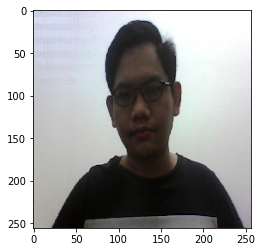

In [ ]:
%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, target_size=(256, 256))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  uploaded_image = np.vstack([x])
  classification_proba = model.predict(uploaded_image)
  image_class = classification_proba.argmax(axis=-1)

  print(fn)

  if image_class[0]==1:
    print('Focus')
  else:
    print('Not Focus')

  print(classification_proba)

Conclusion:

When we do the prediction with image with a person focusing to the camera, the model classify it as "not focus" with 51.3% probability (low confidence). Meanwhile, when we do the prediction with image with a person not focusing to the camera, the model correctly classify it as "not focus" with 95.5% probability (high confidence). The inaccurate classification is due to low number of training epoch that results in 52.15% accuracy score. But from the prediction test, we can intuitively conclude that our model works as it should be. Even though the development is still on low-scale, this notebook is an evidence that "The Sentinel" can be implemented with existing technologies in the (very) near future. We only need to improve further the system.